In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
import plotly.express as px
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from forecasting_func import timeSeriesMultivariate, timeSeriesEvaluationMetrics

In [2]:
# Reading CSV dataset with ANSI encoding as it includes German Tokens

df = pd.read_csv(r"dataset/accidents.csv", encoding = "ANSI")
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunf?le,insgesamt,2021,202101,NaN,28.0,NaN,NaN,NaN
1,Alkoholunf?le,insgesamt,2021,202102,NaN,40.0,NaN,NaN,NaN
2,Alkoholunf?le,insgesamt,2021,202103,NaN,27.0,NaN,NaN,NaN
3,Alkoholunf?le,insgesamt,2021,202104,NaN,26.0,NaN,NaN,NaN
4,Alkoholunf?le,insgesamt,2021,202105,NaN,40.0,NaN,NaN,NaN


In [3]:
# Recognizing first 5 columns for further analysis

df = df.iloc[:, :5]
df = df.dropna()
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
12,Alkoholunf?le,insgesamt,2020,Summe,430.0
13,Alkoholunf?le,insgesamt,2020,202001,28.0
14,Alkoholunf?le,insgesamt,2020,202002,40.0
15,Alkoholunf?le,insgesamt,2020,202003,27.0
16,Alkoholunf?le,insgesamt,2020,202004,26.0


In [4]:
# Renaming Columns to English Counterparts for universal comprehension

df = df.rename(
    columns = {
        'MONATSZAHL':'Category',
        'AUSPRAEGUNG':'AccidentType',
        'JAHR':'Year',
        'MONAT':'Month',
        'WERT':'Value',        
    }
)
df.head()

,Category,AccidentType,Year,Month,Value
12,Alkoholunf?le,insgesamt,2020,Summe,430.0
13,Alkoholunf?le,insgesamt,2020,202001,28.0
14,Alkoholunf?le,insgesamt,2020,202002,40.0
15,Alkoholunf?le,insgesamt,2020,202003,27.0
16,Alkoholunf?le,insgesamt,2020,202004,26.0


In [5]:
# Basic Preprocessing to drop yearly summary value records
# More translation of Categorical Values for ease of comprehension

df.drop(df[df['Month'] == "Summe"].index, inplace = True)

for index, row in df.iterrows():
    if row['Category'] == "Alkoholunf?le":
        df['Category'][index] = "Alcohol Accidents"
    if row['Category'] == "Fluchtunf?le":
        df['Category'][index] = "Escape Accidents"
    if row['Category'] == "Verkehrsunf?le":
        df['Category'][index] = "Traffic Accidents"
    if row['AccidentType'] == "insgesamt":
            df['AccidentType'][index] = "subtotal"
    if row['AccidentType'] == "Verletzte und Get?ete":
            df['AccidentType'][index] = "injured and killed"
    if row['AccidentType'] == "mit Personensch?en":
            df['AccidentType'][index] = "with people"
        
df.head()

<ipython-input-5-1685b44ba39c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category'][index] = "Alcohol Accidents"
<ipython-input-5-1685b44ba39c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccidentType'][index] = "subtotal"
<ipython-input-5-1685b44ba39c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AccidentType'][index] = "injured and killed"
<ipython-input-5-1685b44ba39c>:10: SettingWithCopyWarning: 
A val

,Category,AccidentType,Year,Month,Value
13,Alcohol Accidents,subtotal,2020,202001,28.0
14,Alcohol Accidents,subtotal,2020,202002,40.0
15,Alcohol Accidents,subtotal,2020,202003,27.0
16,Alcohol Accidents,subtotal,2020,202004,26.0
17,Alcohol Accidents,subtotal,2020,202005,40.0


In [6]:
# Counters for each category of accidents is counted manually as the dataframe on itself cannot fully portray this information
# As the subtotal type and injured, death statistics are not mutually exclusive

ctr_alcohol = 0
ctr_escape = 0
ctr_traffic = 0

for index, row in df.iterrows():
    if row['Month'] != "Summe":
        if row["Category"] == "Alcohol Accidents" and row["AccidentType"] == "subtotal":
            ctr_alcohol += row["Value"]
        if row["Category"] == "Escape Accidents" and row["AccidentType"] == "subtotal":
            ctr_escape += row["Value"]
        if row["Category"] == "Traffic Accidents" and row["AccidentType"] == "subtotal":
            ctr_traffic += row["Value"]

# Generating dictionary for plotting
accident_nos = {
    "Alcohol Accidents": ctr_alcohol, 
    "Escape Accidents": ctr_escape, 
    "Traffic Accidents": ctr_traffic
}
print(accident_nos)

{'Alcohol Accidents': 11026.0, 'Escape Accidents': 221616.0, 'Traffic Accidents': 891374.0}


<BarContainer object of 3 artists>

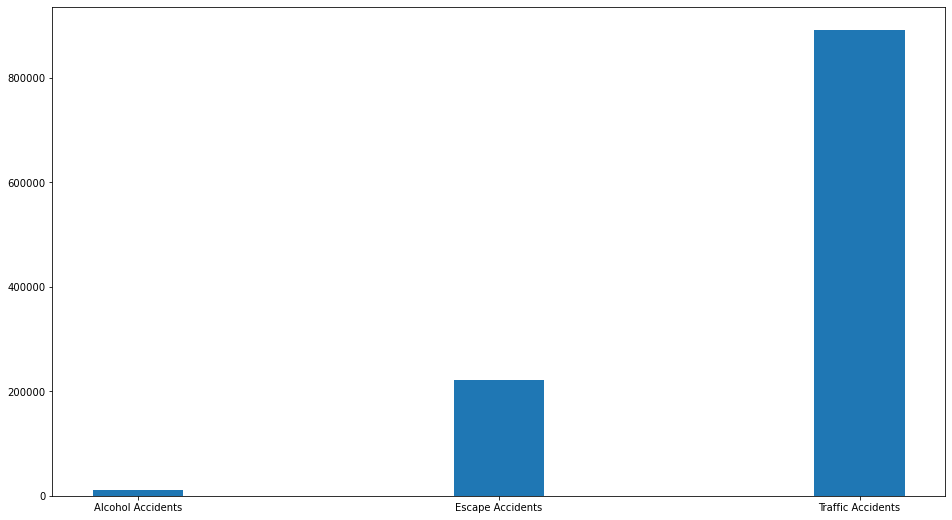

In [7]:
# Histogram Visualization

plt.figure(figsize = (16, 9))
plt.bar(accident_nos.keys(), accident_nos.values(), width=0.25)

In [8]:
# Label Encoding Path.....

# for i in df.select_dtypes('object').columns:
#     le = LabelEncoder().fit(df[i])
#     df[i] = le.transform(df[i]) 

In [9]:
# One Hot Encoding for better results

one_hot_encoded_data = pd.get_dummies(df, columns = ['Category', 'AccidentType'])
one_hot_encoded_data = one_hot_encoded_data.iloc[:, :-1]
one_hot_encoded_data = one_hot_encoded_data.drop(['Category_Traffic Accidents'], axis = 1)
one_hot_encoded_data

,Year,Month,Value,Category_Alcohol Accidents,Category_Escape Accidents,AccidentType_injured and killed,AccidentType_subtotal
13,2020,202001,28.0,1,0,0,1
14,2020,202002,40.0,1,0,0,1
15,2020,202003,27.0,1,0,0,1
16,2020,202004,26.0,1,0,0,1
17,2020,202005,40.0,1,0,0,1
...,...,...,...,...,...,...,...
1990,2000,200008,647.0,0,0,1,0
1991,2000,200009,675.0,0,0,1,0
1992,2000,200010,615.0,0,0,1,0
1993,2000,200011,578.0,0,0,1,0


In [10]:
# More preprocessing to only get the month value from Months Column

for index, row in one_hot_encoded_data.iterrows():
    one_hot_encoded_data.at[index, 'Month'] = row['Month'][-2:]
    one_hot_encoded_data.at[index, 'Month'] = int(row['Month'])
    one_hot_encoded_data.at[index, 'Year'] = int(row['Year'])
    
one_hot_encoded_data.head()

,Year,Month,Value,Category_Alcohol Accidents,Category_Escape Accidents,AccidentType_injured and killed,AccidentType_subtotal
13,2020,202001,28.0,1,0,0,1
14,2020,202002,40.0,1,0,0,1
15,2020,202003,27.0,1,0,0,1
16,2020,202004,26.0,1,0,0,1
17,2020,202005,40.0,1,0,0,1


In [11]:
# fitting multivariate data for forecasting into Min Max Scalers

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_df = X_scaler.fit_transform(one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal','Year', 'Month', 'Value']])
Y_df = Y_scaler.fit_transform(one_hot_encoded_data[['Value']]) 

In [12]:
# Hyperparameters for Time Series Function Forecasting

hist_window = 48
horizon = 12
TRAIN_SPLIT = 1400
x_train, y_train = timeSeriesMultivariate(X_df, Y_df, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = timeSeriesMultivariate(X_df, Y_df, TRAIN_SPLIT, None, hist_window, horizon) 

In [13]:
print ('Multiple window of past history\n')
print(x_train[0])
print(len(x_train[0]))
print ('\n Target horizon\n')
print (y_train[0])
print(len(y_train[0]))

Multiple window of past history

[[1.         0.         0.         1.         1.         0.99453008
  0.00587865]
 [1.         0.         0.         1.         1.         0.99502735
  0.00839807]
 [1.         0.         0.         1.         1.         0.99552461
  0.0056687 ]
 [1.         0.         0.         1.         1.         0.99602188
  0.00545874]
 [1.         0.         0.         1.         1.         0.99651914
  0.00839807]
 [1.         0.         0.         1.         1.         0.99701641
  0.01028763]
 [1.         0.         0.         1.         1.         0.99751367
  0.0121772 ]
 [1.         0.         0.         1.         1.         0.99801094
  0.00965778]
 [1.         0.         0.         1.         1.         0.9985082
  0.00965778]
 [1.         0.         0.         1.         1.         0.99900547
  0.00713836]
 [1.         0.         0.         1.         1.         0.99950273
  0.00482889]
 [1.         0.         0.         1.         1.         1.
  0.00

In [14]:
# Model Training Hyperparameters

batch_size = 128
buffer_size = 128
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [15]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 256)           139264    
_________________________________________________________________
dense (Dense)                (None, 48, 64)            16448     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                7

In [16]:
# Model save files, callbacks, and checkpoints if necessary

# early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
# checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
# callbacks=[early_stopings,checkpoint] 

In [ ]:
# Training the model on all the above parameters and settings, excluding early stopping to attain better yield

history = lstm_model.fit(
    train_data,
    epochs = 40,
    steps_per_epoch = 100,
    validation_data = val_data,
    validation_steps = 50,
    verbose = 1,
    # callbacks=callbacks
)

Epoch 1/40
100/100 [==============================] - 11s 56ms/step - loss: 0.0504 - val_loss: 0.0141
Epoch 2/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0221 - val_loss: 0.0080
Epoch 3/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0135 - val_loss: 0.0071
Epoch 4/40
100/100 [==============================] - 4s 45ms/step - loss: 0.0218 - val_loss: 0.0207
Epoch 5/40
100/100 [==============================] - 4s 45ms/step - loss: 0.0130 - val_loss: 0.0349
Epoch 6/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0114 - val_loss: 0.0345
Epoch 7/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0110 - val_loss: 0.0286
Epoch 8/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0105 - val_loss: 0.0229
Epoch 9/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0107 - val_loss: 0.0331
Epoch 10/40
100/100 [==============================] - 5s 45ms/step - loss: 0.0093 - val_l

In [ ]:
plt.figure(figsize = (16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Accident LSTM Model loss plot')
plt.ylabel('loss axis --->')
plt.xlabel('epochs --->')
plt.legend(['train set loss', 'validation set loss'])
plt.savefig("./plots/loss_curve")
plt.show()

In [ ]:
# Saving model

history.model.save('./models/GermanAccidents_1.h5')
history.model.save('./models/GermanAccidentsWeights_1.h5')

In [ ]:
# Loading Model

loadedModel = load_model('./models/GermanAccidents_1.h5')
loadedModel.summary()

In [ ]:
# Taking inputs for prediction

category = input("Enter Category: ")
accidentType = input("Enter Accident Type: ")
year_ = input("Enter Year: ")
month_ = input("Enter Month: ")

input_df_data = [[1, 0, 0, 1, 2021, 1]]
input_df = pd.DataFrame(input_df_data, columns = ['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Year', 'Month'])

input_df

In [ ]:
input_data = X_scaler.fit_transform(input_df[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal', 'Year', 'Month']])
val_rescaled = input_data.reshape(1, input_data.shape[0], input_data.shape[1])
pred = loadedModel.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
data_val = X_scaler.fit_transform(one_hot_encoded_data[['Category_Alcohol Accidents', 'Category_Escape Accidents', 'AccidentType_injured and killed', 'AccidentType_subtotal','Year', 'Month', 'Value']].tail(48))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = loadedModel.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
loadedModel.predict()

In [ ]:
pred_Inverse[0][2]

In [ ]:
timeSeriesEvaluationMetrics(one_hot_encoded_data['Value'].tail(10), pred_Inverse[0])